<a href="https://colab.research.google.com/github/NiyazovIlia/-Python-Data-Science-2/blob/course-project/GB_DS_2_course_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.Подключение бибилиотек, данных и скрипты

In [1]:
!pip install catboost

In [2]:
import pandas as pd
import numpy as np
import pickle
import random
from pathlib import Path

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

TRAIN_PATH = 'train.csv'
TEST_PATH = 'test.csv'
SUBMIT_PATH = 'sample_submission.csv'

In [3]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

In [4]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [5]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [6]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [7]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [8]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

# 2.Загрузка данных в Data Frame

## Описание файлов
1. train.csv - тренировочные данные
2. test.csv - тестовые данные
3. sampleSubmission.csv - образец файла для отправки в правильном формате

## Описание признаков данных
Home Ownership - домовладение

Annual Income - годовой доход

Years in current job - количество лет на текущем месте работы

Tax Liens - налоговые обременения

Number of Open Accounts - количество открытых счетов

Years of Credit History - количество лет кредитной истории

Maximum Open Credit - наибольший открытый кредит (максимальная сумма, которая когда-либо была доступна клиенту)

Number of Credit Problems - количество проблем с кредитом

Months since last delinquent - количество месяцев с последней просрочки платежа

Bankruptcies - банкротства

Purpose - цель кредита

Term - срок кредита

Current Loan Amount - текущая сумма кредита (сумма, которую еще предстоит выплатить клиенту)

Current Credit Balance - текущий кредитный баланс (сумма, которую может тратить клиент с кредитного счета)

Monthly Debt - ежемесячный долг

Credit Score - баллы кредитного рейтинга

Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [9]:
# Импортируем данные train.csv в pandas Dataframe
df_train = pd.read_csv(TRAIN_PATH, sep=',')
df_test = pd.read_csv(TEST_PATH, sep=',')
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


# 3.EDA

## Основная информация о Data Frame

In [10]:
# Посмотрим основную информацию по все признакам
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [11]:
# Посмотрим основные статистики
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


## Исследование признаков

In [12]:
for i in df_train:
  print('\nКоличество уникальных значений признака ' + i + '\n')
  print(df_train[i].value_counts())


Количество уникальных значений признака Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

Количество уникальных значений признака Annual Income

1161660.0    4
1058376.0    4
1338113.0    4
1043651.0    4
969475.0     4
            ..
1141254.0    1
7907382.0    1
1534478.0    1
972040.0     1
1654786.0    1
Name: Annual Income, Length: 5478, dtype: int64

Количество уникальных значений признака Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

Количество уникальных значений признака Tax Liens

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64

Количество уникальных значений признака Number of Open Accounts

9.0  

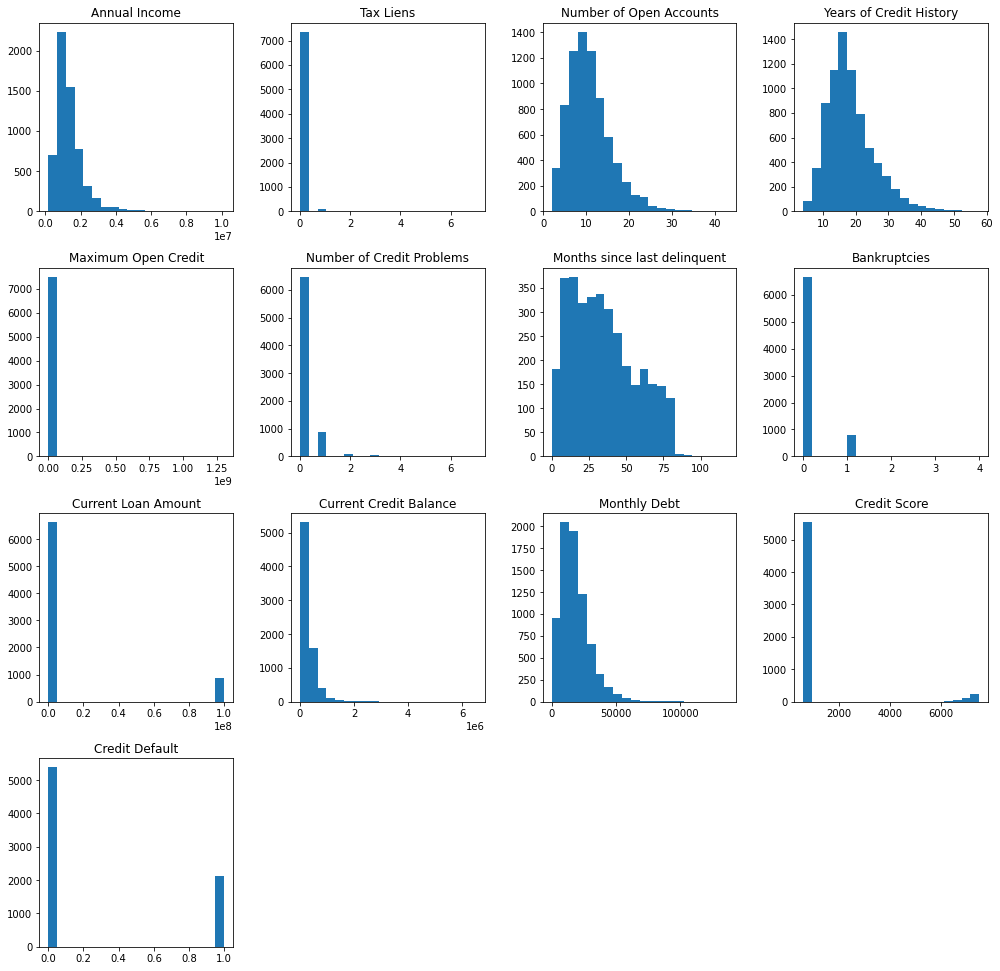

In [13]:
df_train.hist(figsize=(17,17), bins=20, grid=False)
plt.show()

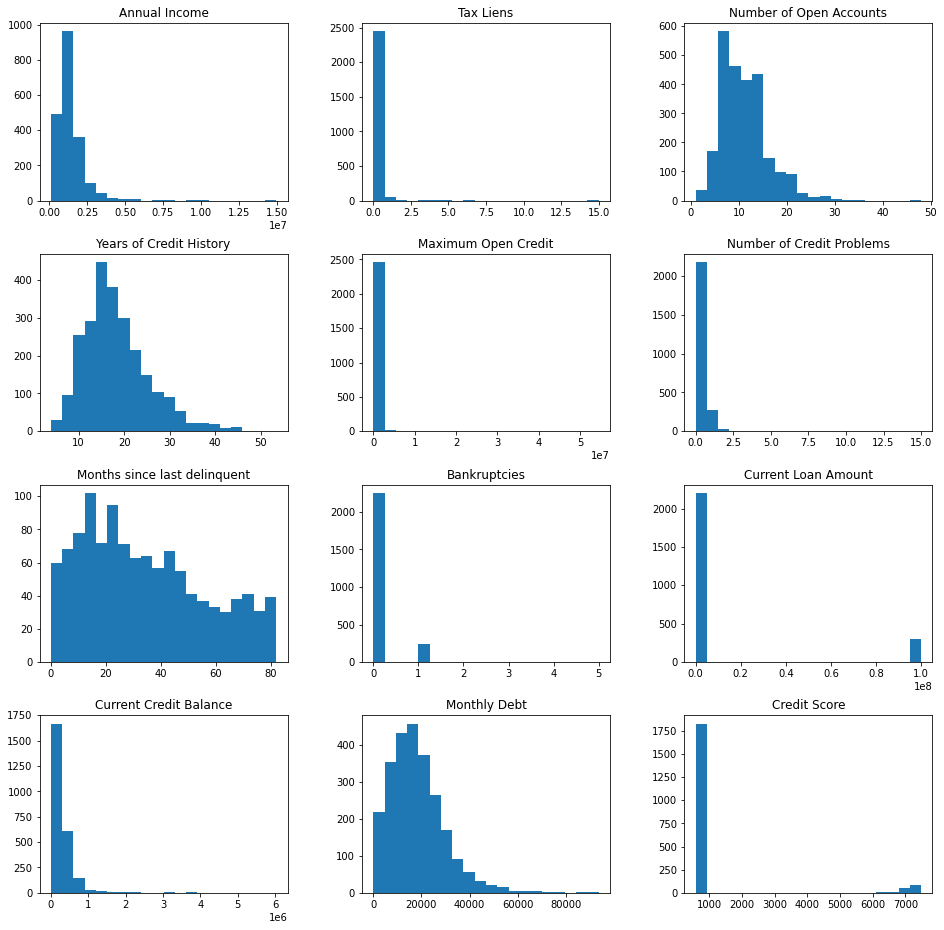

In [14]:
df_test.hist(figsize=(16,16), bins=20, grid=False)
plt.show()

**Если сравнить тестовые и тренировочные данные то видно, что: Number of Open Accounts, Number of credit problems, Months sinse last delinquent и Monthly Debt отличаются.**

## Исследование целевой переменной

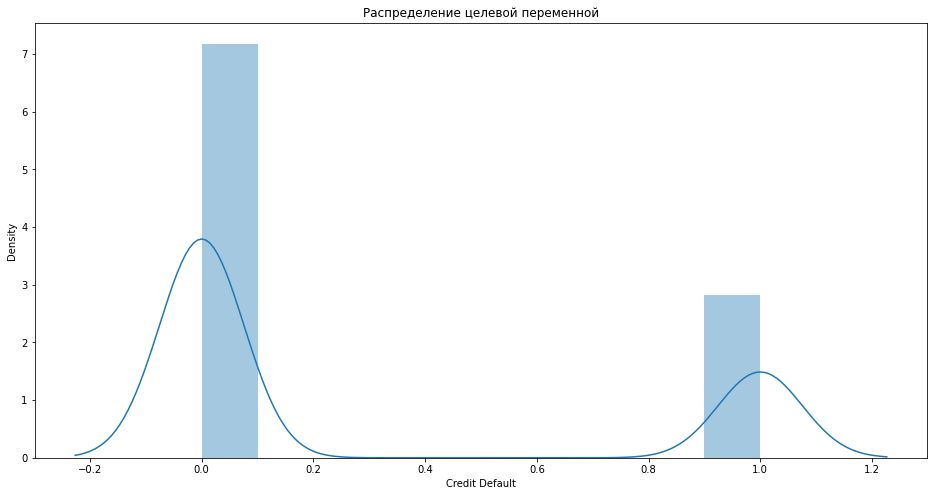

In [15]:
plt.figure(figsize = (16, 8))

sns.distplot(df_train['Credit Default'])

plt.title('Распределение целевой переменной')
plt.show()

## Матрица корреляций

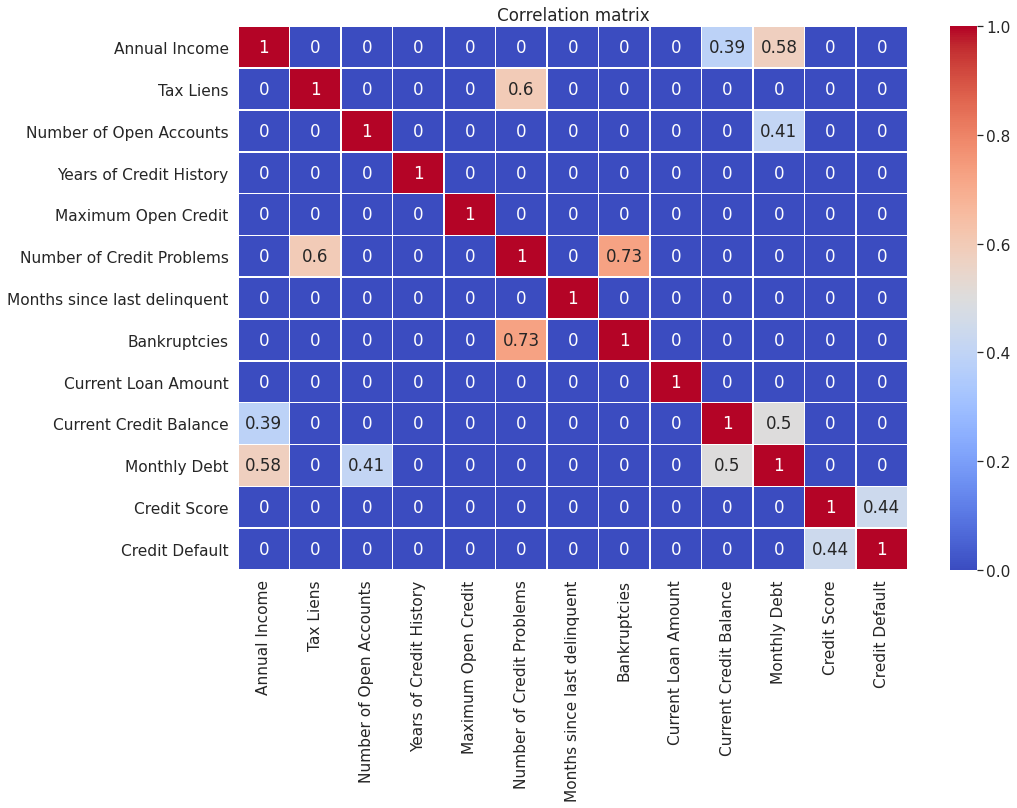

In [16]:
# матрица коореляций
plt.figure(figsize=(15, 10))

sns.set(font_scale=1.4)

corr_matrix = df_train.corr() # вызов корреляции
corr_matrix = np.round(corr_matrix, 2) # сколько знаки после запятой
corr_matrix[np.abs(corr_matrix) < 0.3] = 0 # все что меньше 0,3 по модулю равно 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm') # строим матрицу корреляций

plt.title('Correlation matrix')
plt.show()

**Из матрицы видно что Bunkruptcies и Number of credit problem очень сильно зависят друг от друга**

# 4.Обработка пропусков и замена всех категориальных и словесных признаков на числовые

In [17]:
def imputer_rfr(data, target_col):
    data = data.copy()
    
    features = data.columns
    
    data = data[features]
    
    train = data[~data[target_col].isna()]
    predict_data = data[data[target_col].isna()]

    X = train.drop(columns=target_col)
    y = train[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        random_state=32)
    
    model = GradientBoostingRegressor(n_estimators=110,
                                  max_depth=8,
                                  random_state=42,
                                  loss='huber',
                                  learning_rate=0.2)
    model.fit(X_train, y_train)
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    pred = model.predict(predict_data.drop(columns=target_col))
    data.loc[data[target_col].isna(), target_col] = list(pred)
    return model, data

In [18]:
class DataPreprocessor:
    def __init__(self):
        self.medians = None
        self.years_max_quantille = None
        self.credit_max_quantille = None
        self.loan_quantille = None

    def fit(self, df):
        self.medians = df.median()
        self.years_max_quantille = np.quantile(df['Years of Credit History'], q=0.95)
        self.credit_max_quantille = np.quantile(df['Maximum Open Credit'], q=0.95)
        self.loan_quantille = np.quantile(df['Current Loan Amount'], q=0.88)

                                               
    def transform(self, df):
        # 'Home Ownership'
        df.replace({'Home Ownership': {'Home Mortgage': 0, 
                                       'Rent': 1, 
                                       'Own Home': 2, 
                                       'Have Mortgage': 0,}}, inplace=True)


        # 'Years in current job' 
        # Replace obj with numeric
        df.replace({'Years in current job': 
                                            {'10+ years': 10,
                                             '9 years': 9, 
                                             '8 years': 8,
                                             '7 years': 7, 
                                             '6 years': 6,
                                             '5 years': 5,
                                             '4 years': 4,
                                             '3 years': 3,
                                             '2 years': 2,
                                             '1 year': 1,
                                             '< 1 year': 0,}}, inplace=True)
        # Fillna
        self.years_in_cur_job_median = df['Years in current job'].median()
        df['Years in current job'].fillna(self.years_in_cur_job_median, inplace=True)


        # 'Purpose'
        df.replace({'Purpose': 
                                            {'debt consolidation': 0,
                                             'other': 1, 
                                             'home improvements': 1,
                                             'take a trip': 1, 
                                             'buy a car': 1,
                                             'small business': 2,
                                             'business loan': 2,
                                             'wedding': 1,
                                             'educational expenses': 1,
                                             'buy house': 1,
                                             'medical bills': 1,
                                             'moving': 1,
                                             'major purchase': 1,
                                             'vacation':1,
                                             'renewable energy':1, }}, 
                   inplace=True)
        # Fillna
        df['Purpose'].fillna(1, inplace=True)


        # 'Term'
        df.replace({'Term': {'Short Term': 0, 
                             'Long Term': 1}}, inplace=True)
        

        # 'Months since last delinquent'
        # Fillna with number of credit history months
        df['Months since last delinquent'].fillna((df['Years of Credit History'] * 12), inplace=True)


        # 'Annual Income'
        df['Annual Income'].fillna(1, inplace=True)
        df.loc[df['Annual Income'] > 8000000, ['Annual Income']] = 8000000


        # 'Credit Score'
        df['Credit Score'].fillna(1, inplace=True)
        df.loc[df['Credit Score'] > 850, ['Credit Score']] = df['Credit Score'] / 10
        df.loc[df['Credit Score'] > 1000, ['Credit Score']] = 850


        # 'Bankruptcies'
        df['Bankruptcies'].fillna(0, inplace=True)
        
        
        # 'Years of Credit History'
        df['Years of Credit History'].clip(lower=None, upper=self.years_max_quantille, inplace=True)

        
        
        # Fillna with GBR model
        df.loc[df['Annual Income'] == 1, ['Annual Income']] = np.nan
        model, df = imputer_rfr(df, 'Annual Income')
        

        df.loc[df['Credit Score'] == 1, ['Credit Score']] = np.nan
        model, df = imputer_rfr(df, 'Credit Score')
        


        df.loc[df['Current Loan Amount'] >= self.loan_quantille, ['Current Loan Amount']] = np.nan
        model, df = imputer_rfr(df, 'Current Loan Amount')


        df.loc[df['Maximum Open Credit'] > self.credit_max_quantille, ['Maximum Open Credit']] = np.nan
        model, df = imputer_rfr(df, 'Maximum Open Credit')

        self.months_since_deliq_quantille = np.quantile(df['Months since last delinquent'], q=0.92)
        df.loc[df['Months since last delinquent'] > self.months_since_deliq_quantille, ['Months since last delinquent']] = np.nan
        model, df = imputer_rfr(df, 'Months since last delinquent')


        # 'Number of Open Accounts' 
        df.loc[df['Number of Open Accounts'] > 30, 'Number of Open Accounts'] = 30
        # 'Monthly Debt'
        df.loc[df['Monthly Debt'] > 60000, 'Monthly_Debt_new_pass'] = 60000
        # 'Current Credit Balance'
        df.loc[df['Current Credit Balance'] > 1500000, 'Current Credit Balance'] = 1500000
        # 'Maximum Open Credit'
        df.loc[df['Maximum Open Credit'] > 3000000, 'Maximum Open Credit'] = 3000000
        
        
        # Fillna just in case
        df.fillna(self.medians, inplace=True)

        return df

# 5.Обучение на train

In [19]:
x_train = pd.read_csv(TRAIN_PATH, sep=',')
x_test = pd.read_csv(TEST_PATH, sep=',')

preprocessor = DataPreprocessor()
preprocessor.fit(x_train)
df_train = preprocessor.transform(x_train)
df_test = preprocessor.transform(x_test)

X = df_train[{'Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score'}]
y = df_train['Credit Default']

x_test = df_test[{'Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score'}]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3333, shuffle=True, random_state=21, stratify=y)
print(X_train.shape, X_test.shape, x_test.shape)
print(X_train.isna().sum().sum(), 
      X_test.isna().sum().sum(),
      x_test.isna().sum().sum())

(5000, 16) (2500, 16) (2500, 16)
0 0 0


## Балансировка целевой переменной

In [20]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, 'Credit Default', method='over')
    
df_balanced['Credit Default'].value_counts()

0    3591
1    2818
Name: Credit Default, dtype: int64

In [21]:
X_train = df_balanced.drop(columns='Credit Default')
y_train = df_balanced['Credit Default']

## Построение модели

In [22]:
scaler = StandardScaler()

colnames = X.columns
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=colnames)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=colnames)

model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.90      0.91      0.90      3591
           1       0.89      0.86      0.87      2818

    accuracy                           0.89      6409
   macro avg       0.89      0.89      0.89      6409
weighted avg       0.89      0.89      0.89      6409

TEST

              precision    recall  f1-score   support

           0       0.79      0.77      0.78      1796
           1       0.44      0.47      0.46       704

    accuracy                           0.68      2500
   macro avg       0.61      0.62      0.62      2500
weighted avg       0.69      0.68      0.69      2500

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1374  422
1                371  333


## Подбор гиперпаматеров

In [23]:
# model_catb = catb.CatBoostClassifier(silent=True, random_state=21)

In [24]:
# params = {'n_estimators':[50, 100, 200, 500], 
#           'max_depth':[3, 5, 7, 10],
#           'learning_rate':[0.001, 0.01, 0.05, 0.1]}

In [25]:
# cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [26]:
# %%time

# rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
# rs.fit(X_train, y_train)

In [27]:
# rs.best_params_

In [28]:
# rs.best_score_

## Настрйока модели

In [29]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=200, max_depth=3, learning_rate=0.05,
                                      l2_leaf_reg=10,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.71      0.75      0.73      3591
           1       0.66      0.61      0.63      2818

    accuracy                           0.69      6409
   macro avg       0.69      0.68      0.68      6409
weighted avg       0.69      0.69      0.69      6409

TEST

              precision    recall  f1-score   support

           0       0.80      0.73      0.76      1796
           1       0.43      0.53      0.48       704

    accuracy                           0.67      2500
   macro avg       0.62      0.63      0.62      2500
weighted avg       0.70      0.67      0.68      2500

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1303  493
1                328  376
CPU times: user 958 ms, sys: 52.6 ms, total: 1.01 s
Wall time: 739 ms


# 6.Подбор оптимального размера выборки, кривая обучения

In [30]:
final_model = catb.CatBoostClassifier(n_estimators=500, max_depth=3, learning_rate=0.05,
                                      l2_leaf_reg=10,
                                      class_weights=[1, 3.5],
                                      silent=True, random_state=21)

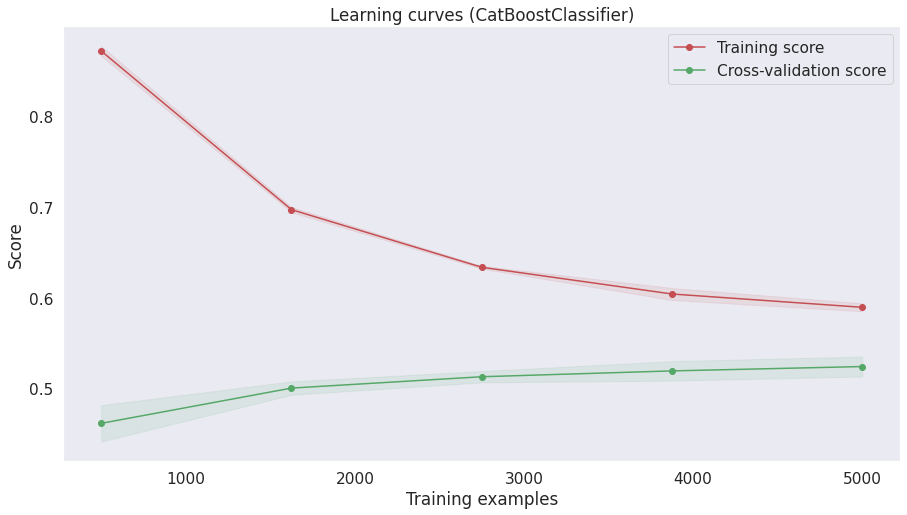

In [31]:
show_learning_curve_plot(final_model, X, y)

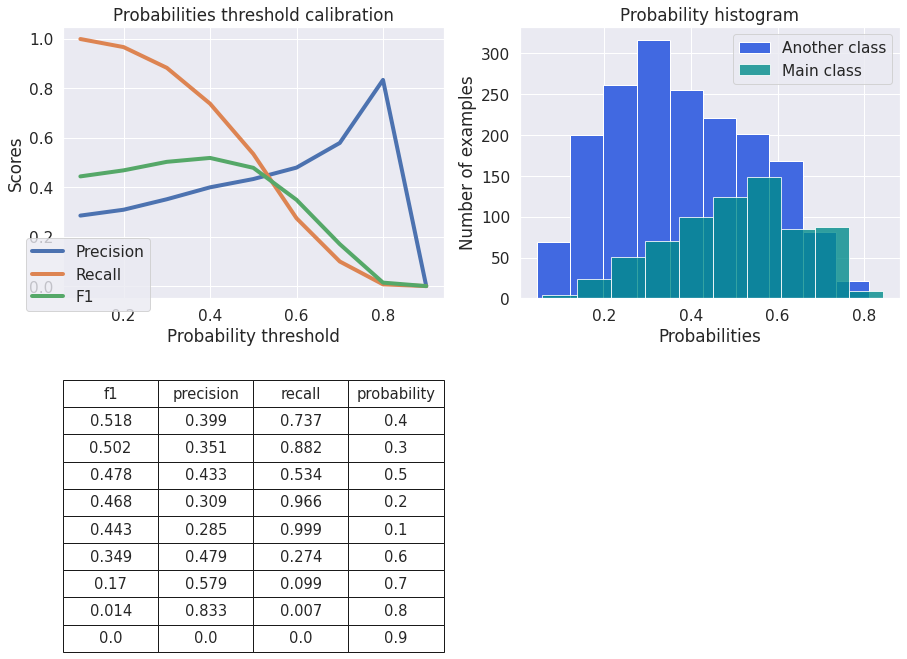

In [32]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

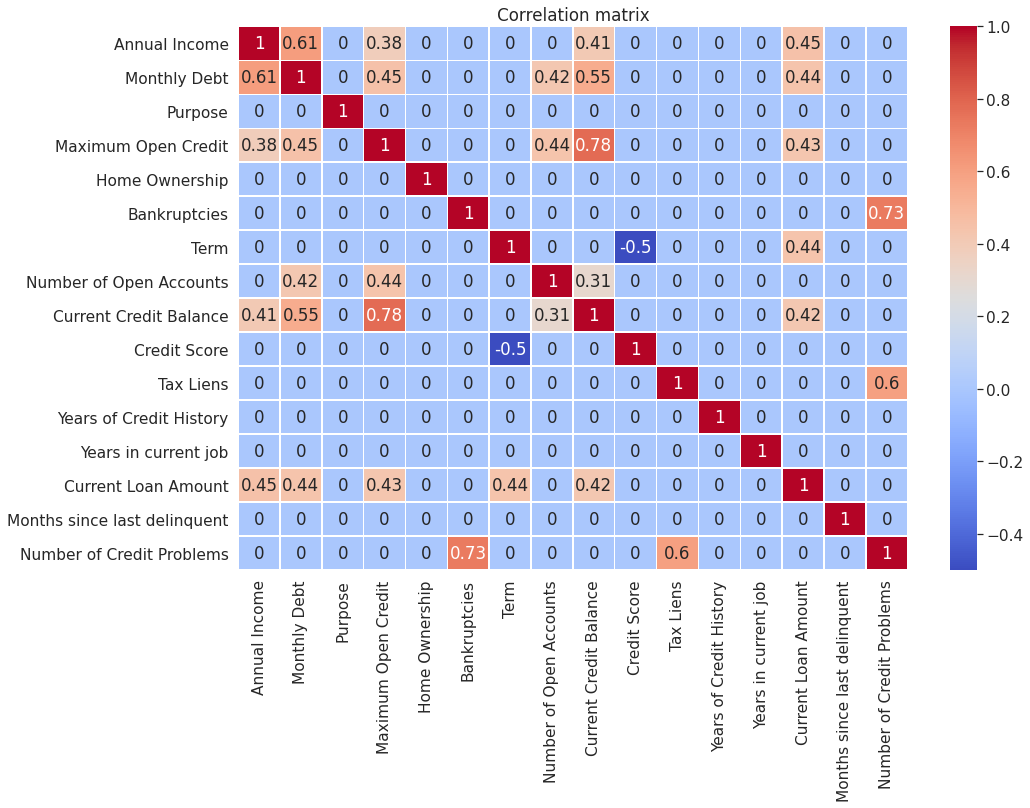

In [33]:
# матрица коореляций
plt.figure(figsize=(15, 10))

sns.set(font_scale=1.4)

corr_matrix = X.corr() # вызов корреляции
corr_matrix = np.round(corr_matrix, 2) # сколько знаки после запятой
corr_matrix[np.abs(corr_matrix) < 0.3] = 0 # все что меньше 0,3 по модулю равно 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm') # строим матрицу корреляций

plt.title('Correlation matrix')
plt.show()

# 7.Финальная модель

In [34]:
disbalance = int(y_train.value_counts()[0]) / int(y_train.value_counts()[1])
disbalance

1.2743080198722498

In [35]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21,
                                    class_weights=[1, disbalance],
                                    allow_writing_files=False,
                                    learning_rate=0.2,
                                    max_depth=3,
                                    eval_metric='F1',
                                    early_stopping_rounds=30,
                                    custom_metric=['Precision', 'Recall'],
                                    subsample=0.8,
                                    l2_leaf_reg=10,)
                                     
model_catb.fit(X_train, y_train, eval_set=(X_test, y_test))

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)
y_test_pred_probs = model_catb.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.72      0.61      0.66      3591
           1       0.58      0.69      0.63      2818

    accuracy                           0.65      6409
   macro avg       0.65      0.65      0.65      6409
weighted avg       0.66      0.65      0.65      6409

TEST

              precision    recall  f1-score   support

           0       0.83      0.62      0.71      1796
           1       0.41      0.68      0.51       704

    accuracy                           0.63      2500
   macro avg       0.62      0.65      0.61      2500
weighted avg       0.71      0.63      0.65      2500

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1109  687
1                227  477


In [36]:
feature_importances = pd.DataFrame(zip(X_train.columns, 
                                       model_catb.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances

,feature_name,importance
0,Annual Income,34.688744
9,Credit Score,32.253509
6,Term,17.951276
13,Current Loan Amount,5.489812
1,Monthly Debt,3.928976
4,Home Ownership,1.492587
2,Purpose,1.465299
14,Months since last delinquent,1.350592
8,Current Credit Balance,0.713684
15,Number of Credit Problems,0.665520


# 8.Обучение на test

In [37]:
predictions = model_catb.predict(x_test)

In [38]:
submit = pd.read_csv(SUBMIT_PATH)
submit.head()

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [39]:
submit['Credit Default'] = predictions
submit.head()

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,0
4,4,1


In [40]:
submit.to_csv('cbc_submit.csv', index=False)